### segment waveform into individual syllables using dynamic thresholding
- 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
import pandas as pd
from datetime import datetime

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import warnings
warnings.filterwarnings(action='once')

In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
DATASET_ID = [
    "woodpecker_dendrocopos_leucotos",
    "woodpecker_dendrocopos_major",
    "woodpecker_dendrocopos_medius",
    "woodpecker_dendrocopos_minor",
    "woodpecker_dryocopus_martius",
    "woodpecker_jynx_torquilla",
    "woodpecker_picus_viridis",
]

### Load data in original format

In [7]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2019-10-07_21-43-39'

### create dataset

In [8]:
hparams = HParams(
    n_fft = 1024,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=20000,
    butter_lowcut = 500,
    butter_highcut = 20000,
    ref_level_db = 25,
    min_level_db = -100,
    win_length_ms = 4,
    hop_length_ms = 1,
    n_jobs = -1,
    verbosity=1,
    nex = -1
)

In [9]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/avgn/utils/json.py:64: ResourceWarning: unclosed file <_io.TextIOWrapper name='/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/woodpecker_dendrocopos_leucotos/2019-06-24_14-29-55/JSON/XC331530-DendrocoposLeucotos-call-19.JSON' mode='r' encoding='UTF-8'>
  return json.load(open(json_loc), object_pairs_hook=OrderedDict)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s


[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1145 out of 1145 | elapsed:    5.5s finished


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:5605: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/AD/tsainbur/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/ops/signal/util_ops.py:62: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  return ops.convert_to_tensor(fractions.gcd(const_a, const_b))


In [10]:
dataset.sample_json

OrderedDict([('indvs', OrderedDict([('UNK', OrderedDict())])),
             ('species', 'Dendrocopos leucotos'),
             ('common_name', 'Whick-backed woodpecker'),
             ('wav_loc',
              '/mnt/cube/Datasets/Picidae/PicidaeDataset/DendrocoposLeucotos-call/XC331530-DendrocoposLeucotos-call-19.wav'),
             ('sound_type', 'call'),
             ('origin', 'XC331530'),
             ('samplerate_hz', 44100),
             ('length_s', 1.0)])

### segment and plot 
- for each json, load the wav file - segment the file into start and end times
- plot the segmentation
- add to the JSON 

In [11]:
from avgn.utils.audio import load_wav
from avgn.signalprocessing.filtering import butter_bandpass_filter
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [12]:
from vocalseg.dynamic_thresholding import plot_segmented_spec, plot_segmentations

In [13]:
import joblib

In [14]:
### segmentation parameters
n_fft=1024
hop_length_ms=1
win_length_ms=4
ref_level_db=20
pre=0.97
min_level_db=-40
min_level_db_floor = -10
db_delta = 5
silence_threshold = 0.01
min_silence_for_spec=0.25
max_vocal_for_spec=0.25,
min_syllable_length_s = 0.0125
butter_min = 500
butter_max = 15999
spectral_range = [500, 15999]

In [15]:
from avgn.utils.json import NoIndent, NoIndentEncoder

In [16]:
warnings.filterwarnings("ignore", message = "'tqdm_notebook' object has no attribute 'sp'")
def segment_spec_custom(key, df, save=False, plot=False):
    # load wav
    rate, data = load_wav(df.data["wav_loc"])
    # filter data
    data = butter_bandpass_filter(data, butter_min, butter_max, rate)

    # segment
    results = dynamic_threshold_segmentation(
        data,
        rate,
        n_fft=n_fft,
        hop_length_ms=hop_length_ms,
        win_length_ms=win_length_ms,
        min_level_db_floor=min_level_db_floor,
        db_delta=db_delta,
        ref_level_db=ref_level_db,
        pre=pre,
        min_silence_for_spec=min_silence_for_spec,
        max_vocal_for_spec=max_vocal_for_spec,
        min_level_db=min_level_db,
        silence_threshold=silence_threshold,
        verbose=True,
        min_syllable_length_s=min_syllable_length_s,
        spectral_range=spectral_range,
    )
    if results is None:
        print('skipping')
        return
    if plot:
        plot_segmentations(
            results["spec"],
            results["vocal_envelope"],
            results["onsets"],
            results["offsets"],
            hop_length_ms,
            rate,
        )
        plt.show()

    # save the results
    json_out = DATA_DIR / "processed" / ('woodpecker' + "_segmented") / DT_ID / "JSON" / (
        key + ".JSON"
    )
    #print(json_out)

    json_dict = df.data.copy()

    json_dict["indvs"][list(df.data["indvs"].keys())[0]]["syllables"] = {
        "start_times": NoIndent(list(results["onsets"])),
        "end_times": NoIndent(list(results["offsets"])),
    }

    json_txt = json.dumps(json_dict, cls=NoIndentEncoder, indent=2)
    # save json
    if save:
        ensure_dir(json_out.as_posix())
        print(json_txt, file=open(json_out.as_posix(), "w"))

    #print(json_txt)

    return results

In [17]:
species = np.array([i.data['species'] for i in dataset.data_files.values()])
len(species)

1145

In [18]:
np.unique(species)

array(['Dendrocopos leucotos', 'Dendrocopos major', 'Dendrocopos medius',
       'Dendrocopos minor', 'Dryocopus martius', 'Jynx torquilla',
       'Picus viridis'], dtype='<U20')

In [19]:
pd.DataFrame({indv:[np.sum(species == indv)] for indv in np.unique(species)})

,Dendrocopos leucotos,Dendrocopos major,Dendrocopos medius,Dendrocopos minor,Dryocopus martius,Jynx torquilla,Picus viridis
0,196,208,166,232,193,102,48


Dendrocopos leucotos


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


longest silence 0.9639999999999999
longest vocalization 0.03


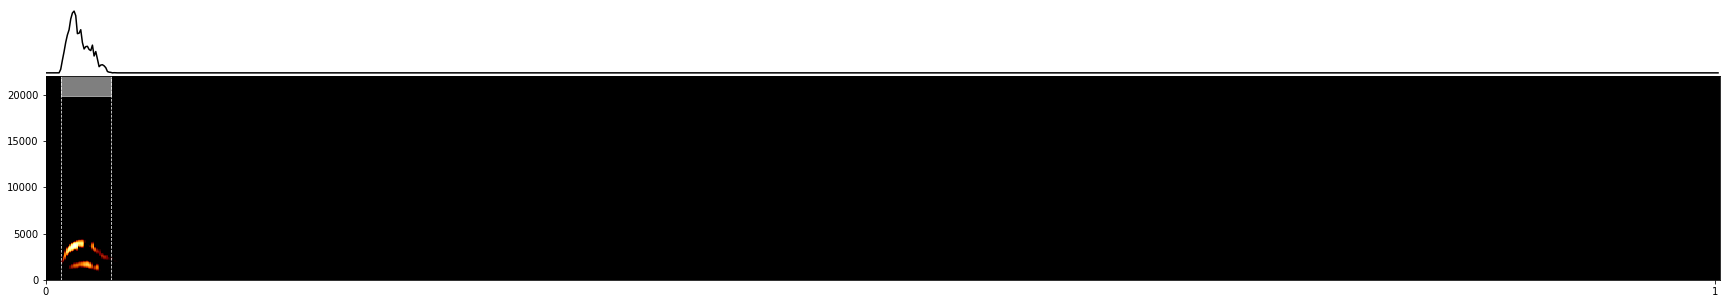

longest silence 0.27199999999999996
longest vocalization 0.11099999999999999


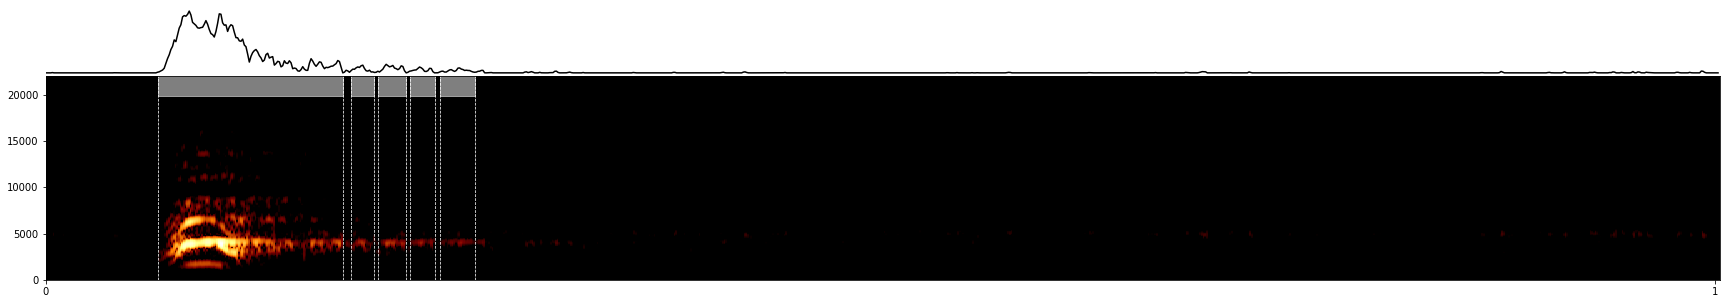

longest silence 0.7949999999999999
longest vocalization 0.08399999999999999


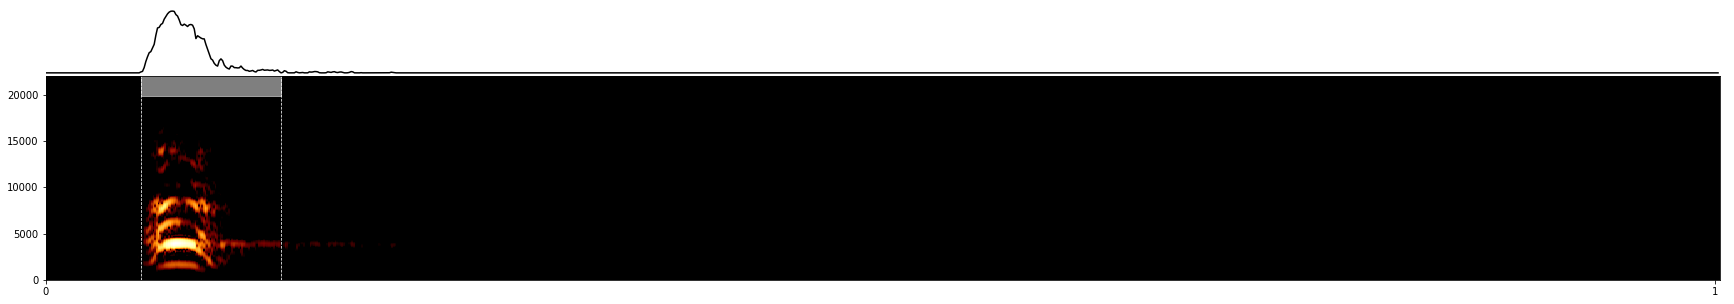

Dendrocopos major


longest silence 0.268
longest vocalization 0.08899999999999997


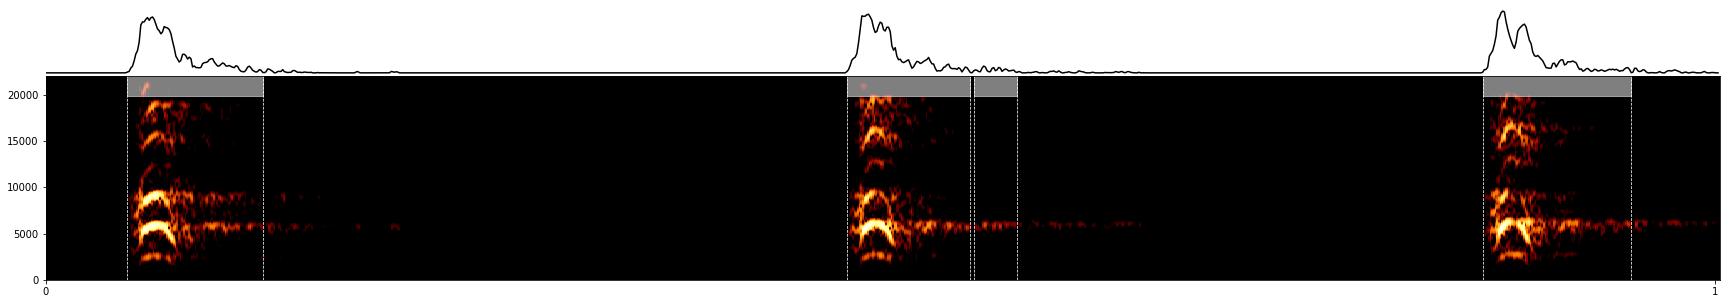

longest silence 0.07499999999999996
longest vocalization 0.127
Current min_level_db: -40
longest silence 0.10599999999999998
longest vocalization 0.06699999999999999
Current min_level_db: -35
longest silence 0.11399999999999999
longest vocalization 0.063
Current min_level_db: -30
longest silence 0.13
longest vocalization 0.052
Current min_level_db: -25
longest silence 0.5189999999999999
longest vocalization 0.008000000000000007


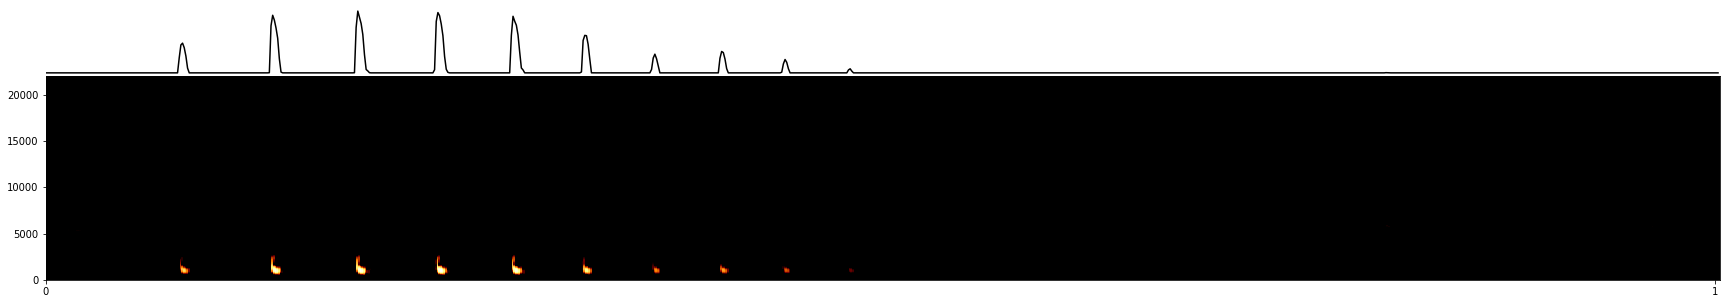

longest silence 0.21099999999999985
longest vocalization 0.19600000000000006
Current min_level_db: -40
longest silence 0.22599999999999998
longest vocalization 0.05400000000000005
Current min_level_db: -35
longest silence 0.41999999999999993
longest vocalization 0.03400000000000003


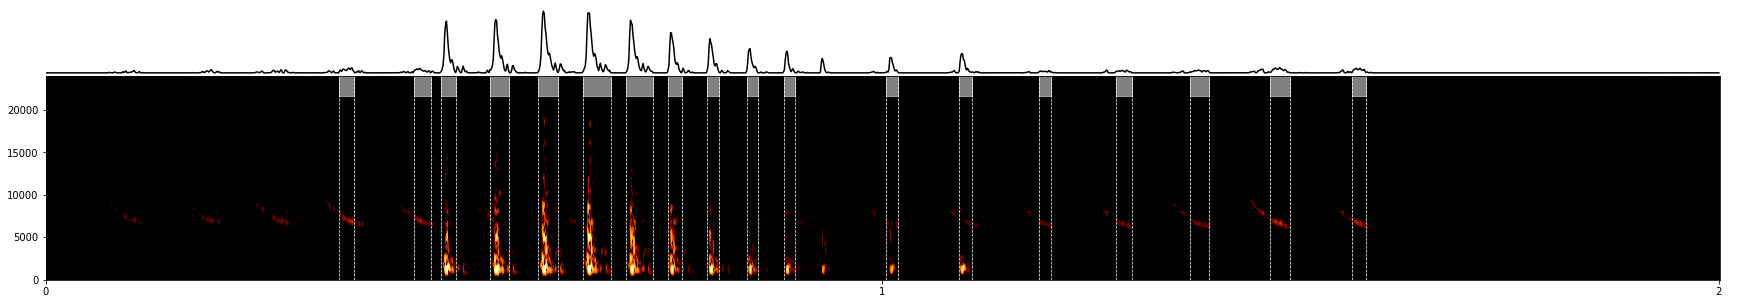

Dendrocopos medius


longest silence 0.03200000000000003
longest vocalization 0.5409999999999999
Current min_level_db: -40
longest silence 0.1589999999999998
longest vocalization 0.1399999999999999
Current min_level_db: -35
longest silence 0.2869999999999999
longest vocalization 0.05700000000000016


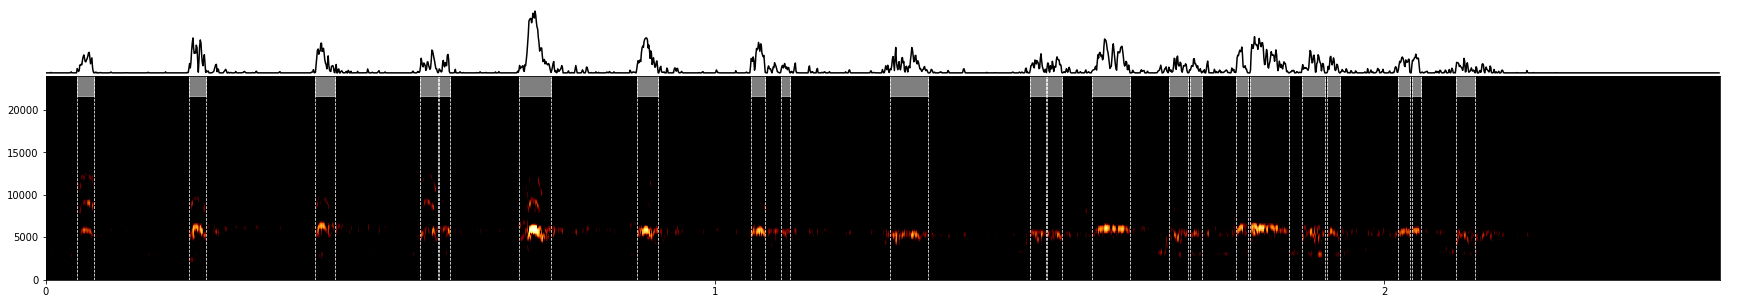

longest silence 0.03699999999999999
longest vocalization 0.13699999999999996
Current min_level_db: -40
longest silence 0.041999999999999996
longest vocalization 0.133
Current min_level_db: -35
longest silence 0.045
longest vocalization 0.05800000000000005
Current min_level_db: -30
longest silence 0.05
longest vocalization 0.05300000000000005
Current min_level_db: -25
longest silence 0.126
longest vocalization 0.03400000000000003
Current min_level_db: -20
longest silence 0.175
longest vocalization 0.02300000000000002
Current min_level_db: -15
skipping


longest silence 0.126
longest vocalization 0.344
Current min_level_db: -40
longest silence 0.23099999999999998
longest vocalization 0.31900000000000006
Current min_level_db: -35
longest silence 0.236
longest vocalization 0.281
Current min_level_db: -30
longest silence 0.28600000000000003
longest vocalization 0.257
Current min_level_db: -25
longest silence 0.46099999999999997
longest vocalization 0.22999999999999998


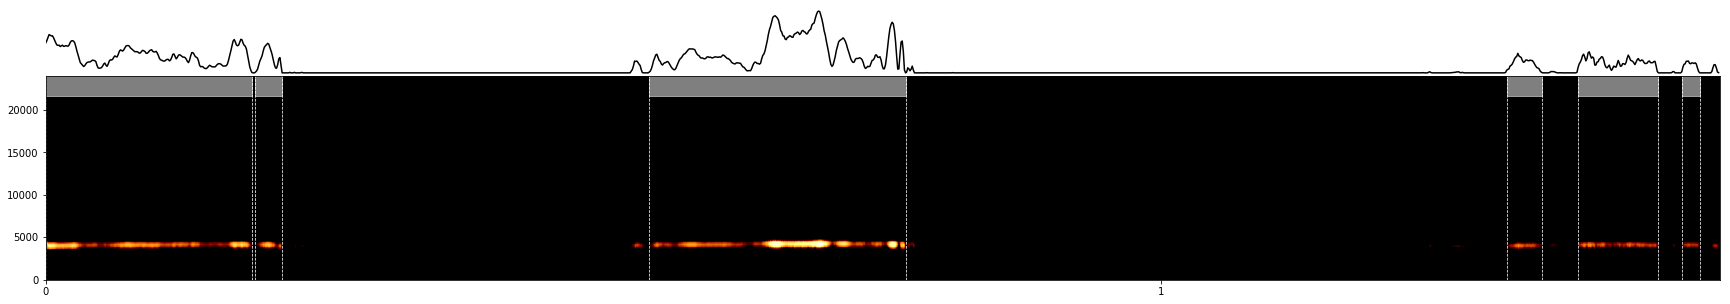

Dendrocopos minor


longest silence 0.7739999999999998
longest vocalization 0.038000000000000034


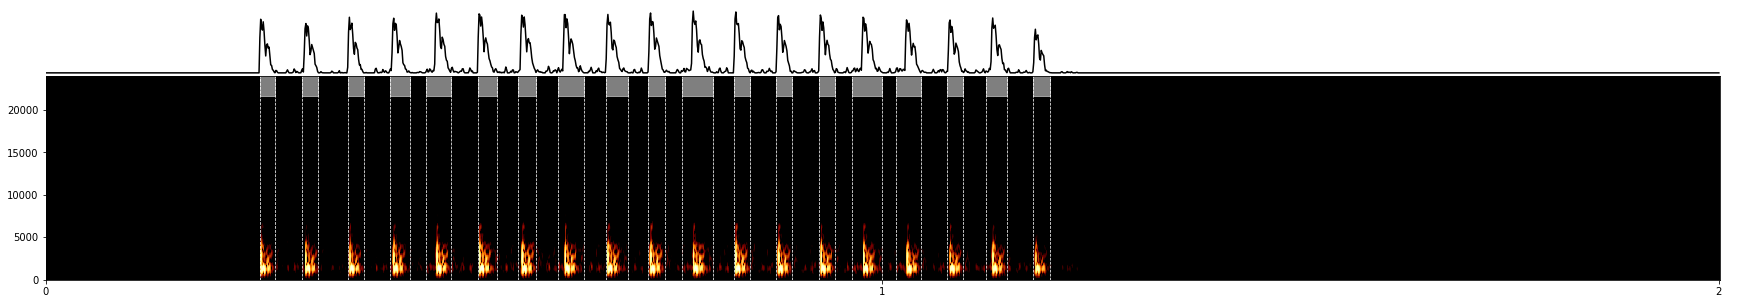

longest silence 0.028000000000000025
longest vocalization 0.06500000000000006
Current min_level_db: -40
longest silence 0.08899999999999997
longest vocalization 0.02100000000000002
Current min_level_db: -35
longest silence 0.3740000000000001
longest vocalization 0.010000000000000009


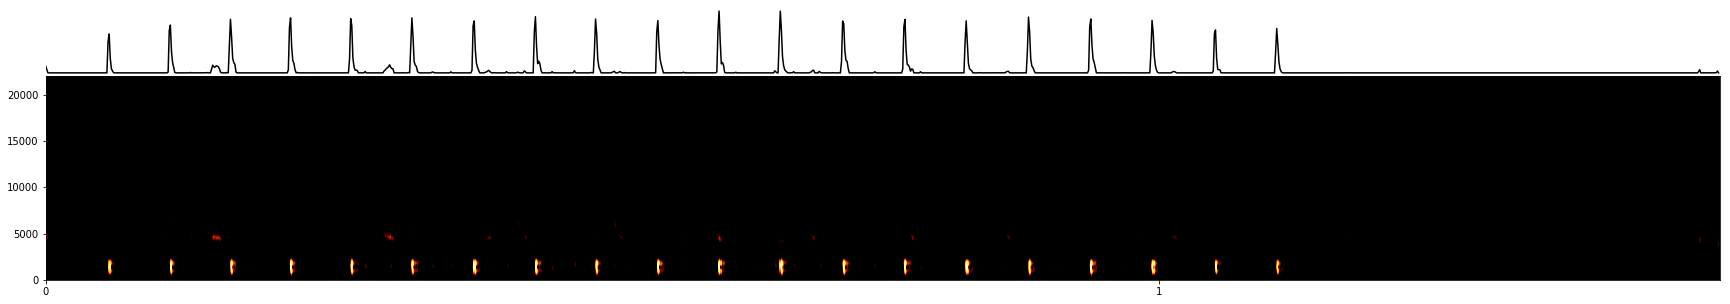

longest silence 0.19200000000000006
longest vocalization 0.06
Current min_level_db: -40
longest silence 0.2749999999999999
longest vocalization 0.03799999999999998


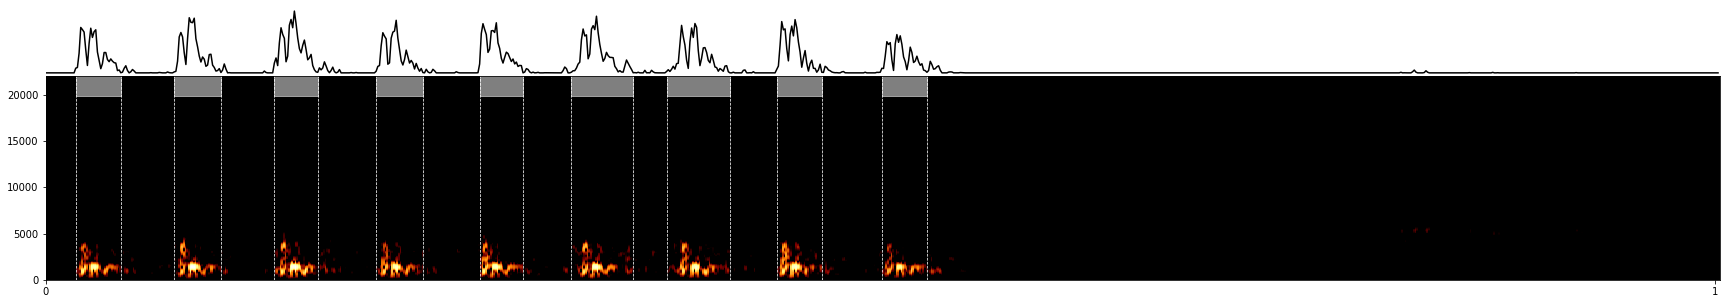

Dryocopus martius


longest silence 0.13900000000000023
longest vocalization 0.543
Current min_level_db: -40
longest silence 0.3360000000000003
longest vocalization 0.134


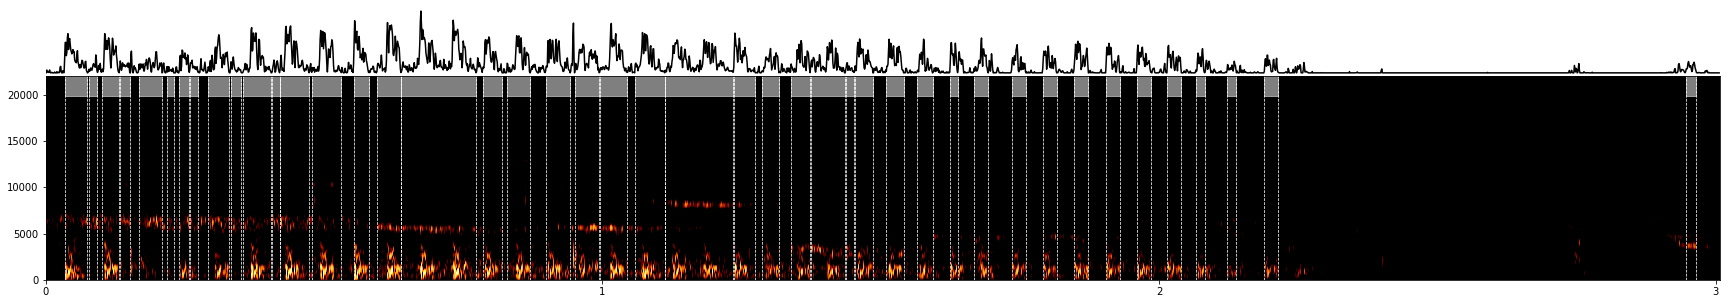

longest silence 0.15000000000000002
longest vocalization 0.40700000000000003
Current min_level_db: -40
longest silence 0.329
longest vocalization 0.244


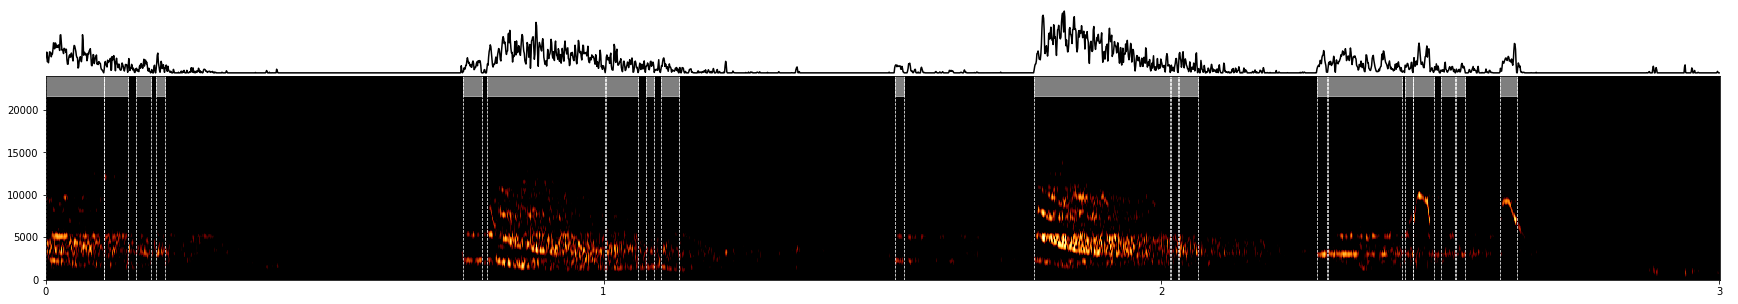

longest silence 0.39
longest vocalization 0.759
Current min_level_db: -40
longest silence 0.39
longest vocalization 0.7579999999999999
Current min_level_db: -35
longest silence 0.39
longest vocalization 0.45299999999999996
Current min_level_db: -30
longest silence 0.589
longest vocalization 0.026000000000000023


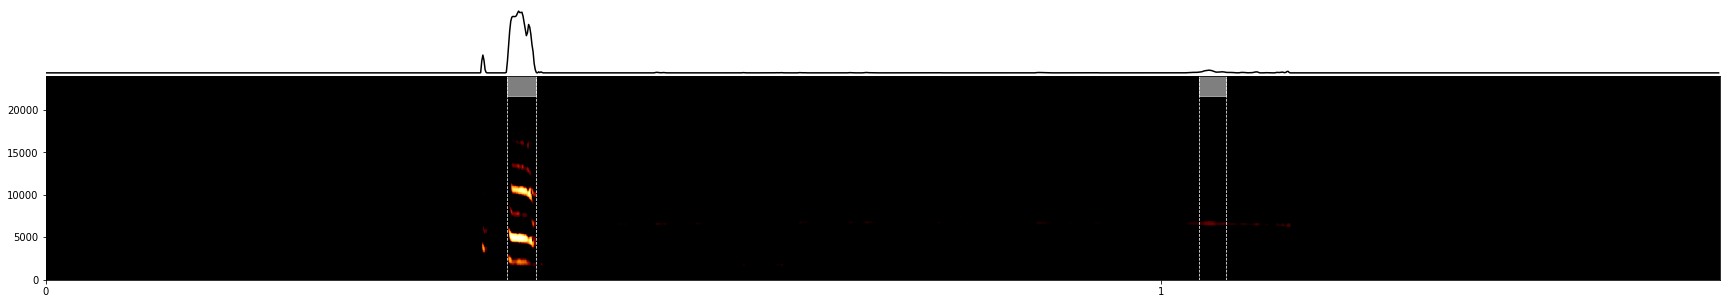

Jynx torquilla


longest silence 0.121
longest vocalization 0.17400000000000015
Current min_level_db: -40
longest silence 0.14500000000000002
longest vocalization 0.13999999999999968
Current min_level_db: -35
longest silence 0.23900000000000032
longest vocalization 0.13400000000000012
Current min_level_db: -30
longest silence 0.573
longest vocalization 0.12200000000000011


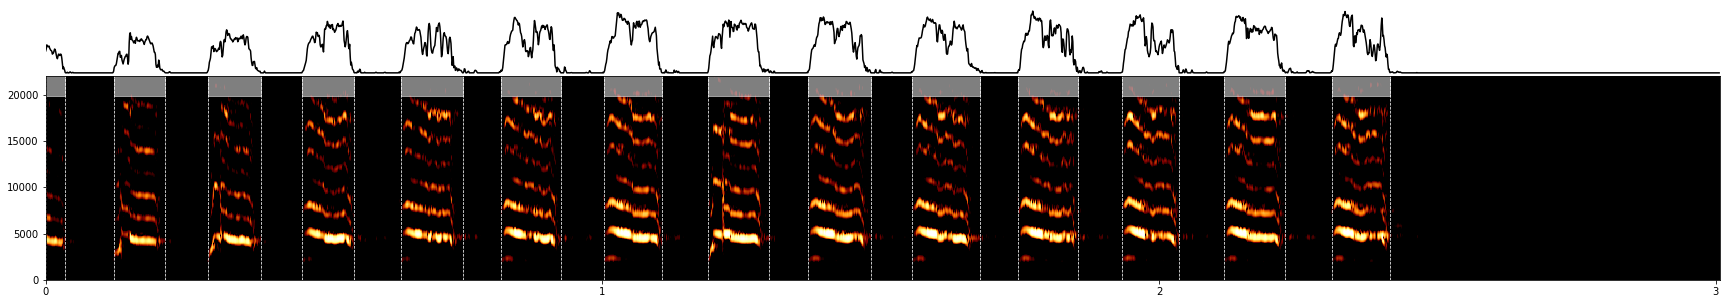

longest silence 0.5529999999999999
longest vocalization 0.16900000000000004


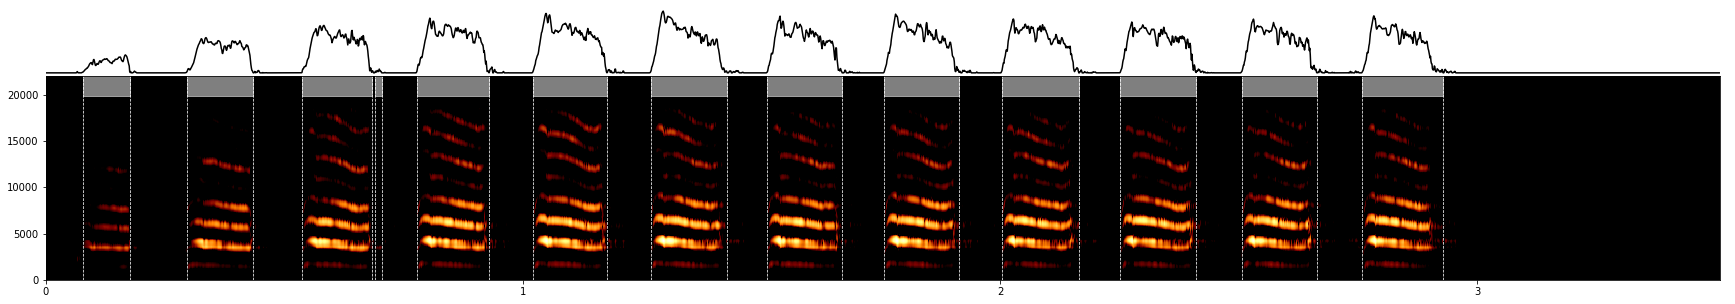

longest silence 0.13900000000000023
longest vocalization 0.15400000000000014
Current min_level_db: -40
longest silence 0.15799999999999992
longest vocalization 0.14500000000000002
Current min_level_db: -35
longest silence 0.3210000000000002
longest vocalization 0.12400000000000011


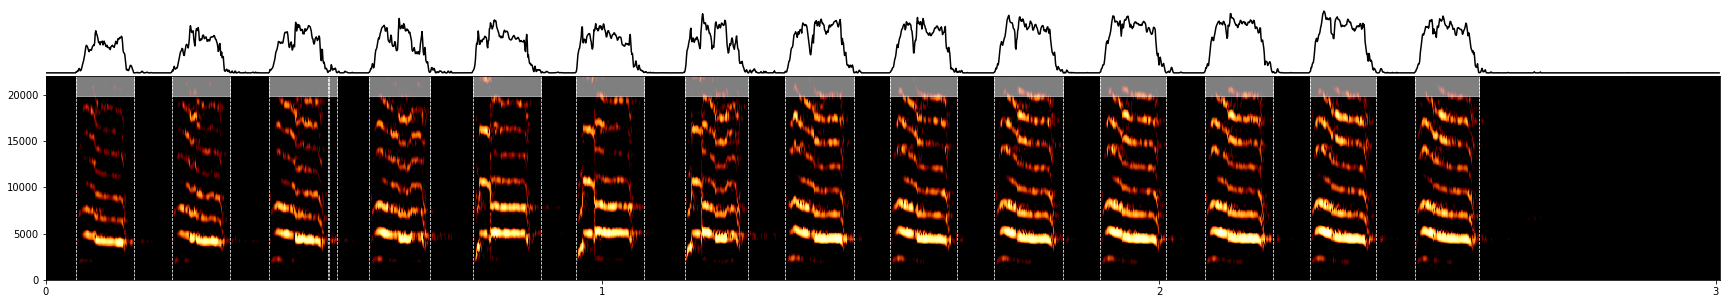

Picus viridis


longest silence 0.1489999999999998
longest vocalization 0.9369999999999999
Current min_level_db: -40
longest silence 0.2809999999999999
longest vocalization 0.40800000000000003
Current min_level_db: -35
longest silence 0.32499999999999996
longest vocalization 0.19199999999999995


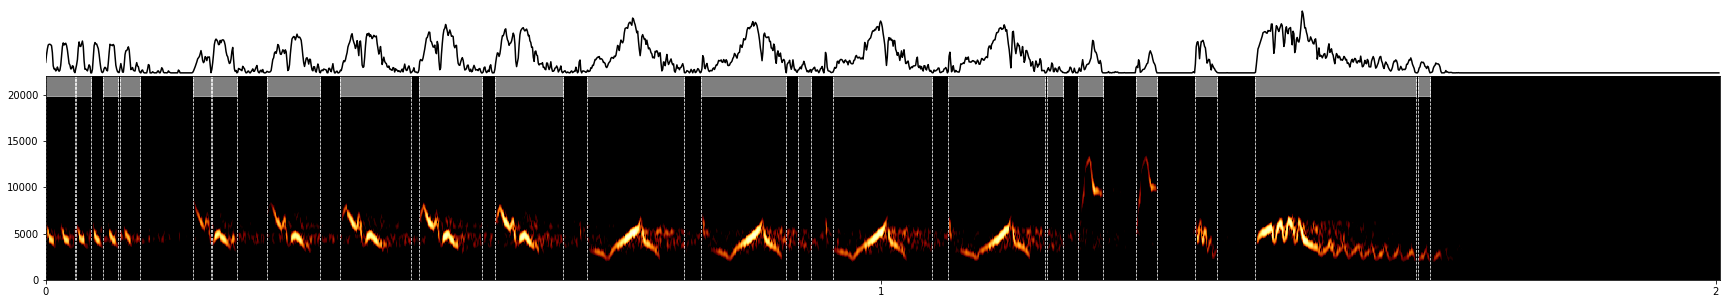

longest silence 0.33999999999999986
longest vocalization 0.12999999999999998


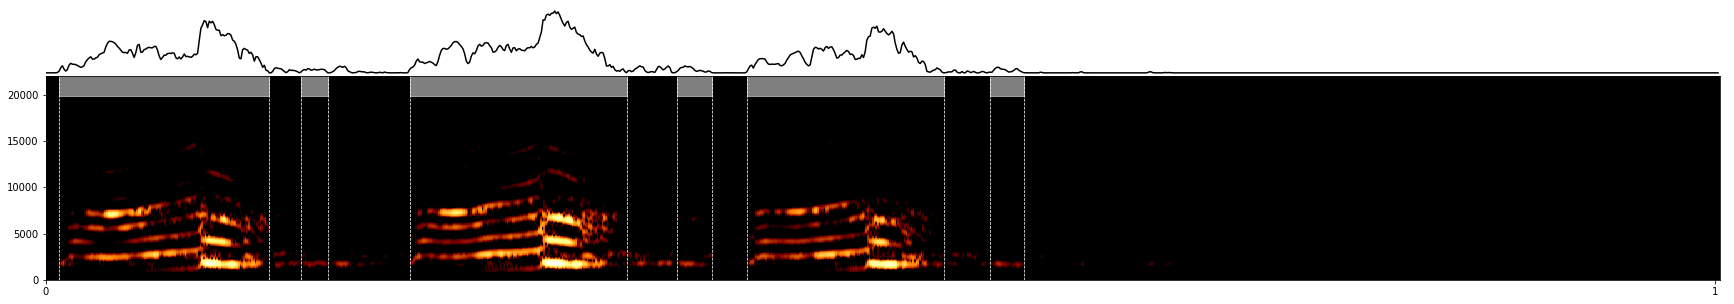

longest silence 0.15700000000000003
longest vocalization 0.346
Current min_level_db: -40
longest silence 0.29800000000000026
longest vocalization 0.133


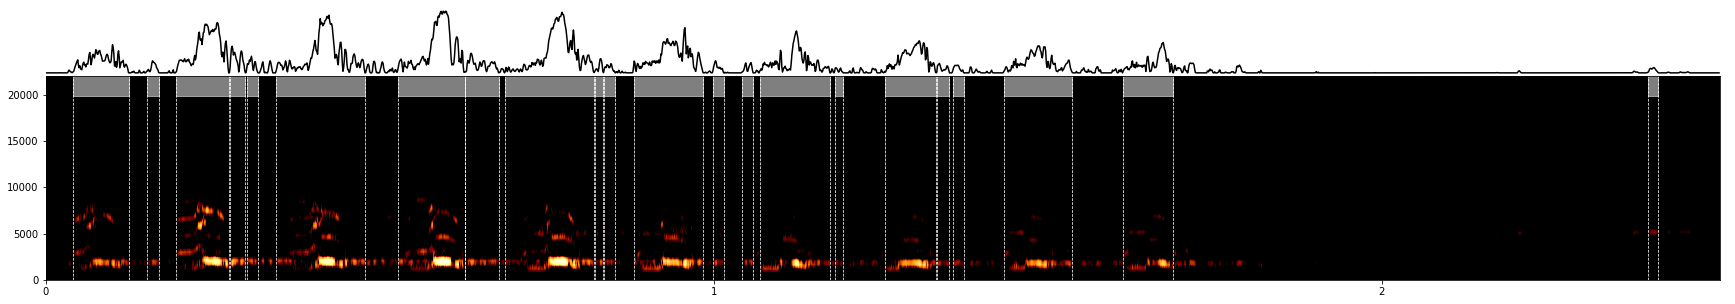

In [20]:
nex = 3
for indv in tqdm(np.unique(species)[:10], desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[species == indv][:nex]

    joblib.Parallel(n_jobs=1, verbose=0)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], plot=True) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )

### Generate for full dataset

In [21]:
species = np.array([i.data['species'] for i in dataset.data_files.values()])
len(species)

np.unique(species)

array(['Dendrocopos leucotos', 'Dendrocopos major', 'Dendrocopos medius',
       'Dendrocopos minor', 'Dryocopus martius', 'Jynx torquilla',
       'Picus viridis'], dtype='<U20')

In [22]:
nex = -1
for indv in tqdm(np.unique(species), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[species == indv][:nex]


    joblib.Parallel(n_jobs=10, verbose=11)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], save=True) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )

Dendrocopos leucotos


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

Dendrocopos major


[Parallel(n_jobs=10)]: Done 195 out of 195 | elapsed:    3.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Batch computation too fast (0.0757s.) Setting batch_size=4.
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  14 ta

Dendrocopos medius


[Parallel(n_jobs=10)]: Done 188 out of 207 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 207 out of 207 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 207 out of 207 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Batch computation too fast (0.0734s.) Setting batch_size=4.
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  14 ta

Dendrocopos minor


[Parallel(n_jobs=10)]: Done 165 out of 165 | elapsed:    3.9s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

Dryocopus martius


[Parallel(n_jobs=10)]: Done 231 out of 231 | elapsed:    5.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1212s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  14 ta

Jynx torquilla


[Parallel(n_jobs=10)]: Done 192 out of 192 | elapsed:    4.9s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1529s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  14 ta

Picus viridis


[Parallel(n_jobs=10)]: Done 101 out of 101 | elapsed:    2.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Batch computation too fast (0.0799s.) Setting batch_size=4.
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  13 out of  47 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  18 out of  47 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=10)]: Done  23 out of  47 | elapsed:    0.8s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  43 out of  47 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=10)